In [3]:
import os 
from dotenv import load_dotenv
load_dotenv() # loading all the environment variable

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

c:\Deepak\AgenticAIWorkshop\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore  = FAISS.from_documents(
    documents=doc_splits,
    embedding=embeddings
)

retreiver = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
### Router

from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relavant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with function call
llm = ChatGroq(model='llama3-70b-8192')
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system="""You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains document related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for the questions on these topics, Otherwise, use web search."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt |structured_llm_router

print(question_router.invoke({"question": "What are the types of  agent memory"}))

datasource='vectorstore'


In [7]:
## Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

llm = ChatGroq(model='llama3-70b-8192')
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# prompt
system = """You are a grader assessing relevance of a retreived document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
It does not need to be a stringent test. The goal is to filter out erroneous retreivals. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

question = "agent memory" 
docs = retreiver.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [8]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatGroq(model='llama3-70b-8192')

# Post-processing
# def format_docs(docs):
#     return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

c:\Deepak\AgenticAIWorkshop\venv\Lib\site-packages\langsmith\client.py:280: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


An agent's memory consists of short-term memory and long-term memory. Short-term memory is utilized through in-context learning and enables the agent to learn from the model. Long-term memory provides the agent with the capability to retain and recall information over extended periods, often by leveraging an external vector store and fast retrieval.


In [9]:
### Hallucination Grader

# Data Model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_Score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

    # LLM with function call

llm = ChatGroq(model='llama3-70b-8192')
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """you are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts"""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation":generation})


GradeHallucinations(binary_Score='yes')

In [10]:
### Answer Grader

class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatGroq(model='llama3-70b-8192')
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
Give a binary score 'yes' or 'no' . 'Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),

    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [11]:
### Question Re-writer

# LLM
llm = ChatGroq(model='llama3-70b-8192')

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human", "Here si the initial quesiton: \n\n {question} \n Formulate an improved question."),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Here\'s a rewritten question that\'s optimized for vector store retrieval:\n\n"What are the key concepts and mechanisms related to memory in artificial intelligence agents?"\n\nThis question aims to capture the underlying semantic intent of the original question by:\n\n1. Adding context: Specifying that the question is related to artificial intelligence agents.\n2. Clarifying the scope: Focusing on key concepts and mechanisms rather than a broad term like "agent memory".\n3. Providing a clear direction for the vector store to retrieve relevant information.\n\nThis rewritten question is more specific, clear, and concise, making it easier for the vector store to retrieve relevant and accurate information.'

In [12]:
### search 

from dotenv import load_dotenv
load_dotenv()

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [13]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.
    
    Attributes:
    question: question
    generation: LLM generation
    documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [14]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state(dict): New key added to state, documents, that contains retrieved documents
    """

    print("---Retrieve---")
    question = state["question"]

    # Retrieval
    documents = retreiver.invoke(question)
    return {"documents" : documents, "question": question}


def generate(state):
    """
    Generate answer
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines wheter the retrieved documents are relevant to the quesiton.
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == 'yes':
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)

        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.
    
    Args:
        state (dict): The current grapg state
        
    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    #Re- write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    quesiton = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ##

def route_question(state):
    """
    Route question to web search or RAG.
    
    Args:
        state (dict): The current graph state
        
    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    
    Args: state (dict): The current graph state
    
    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENT---")
    filtered_documents = state["question"]
    
    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"
    

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answer question.
    
    Args:
        state(dict): The current graph state
    
    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question =  state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "genaration": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"




In [15]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

In [16]:
from pprint import pprint

# Run
inputs = {
    "question": "What player at the Bears expected to draft first in the 2024 NFL draft?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---


KeyError: "Input to ChatPromptTemplate is missing variables {'generation'}.  Expected: ['documents', 'generation'] Received: ['documents', 'genaration']\nNote: if you intended {generation} to be part of the string and not a variable, please escape it with double curly braces like: '{{generation}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "

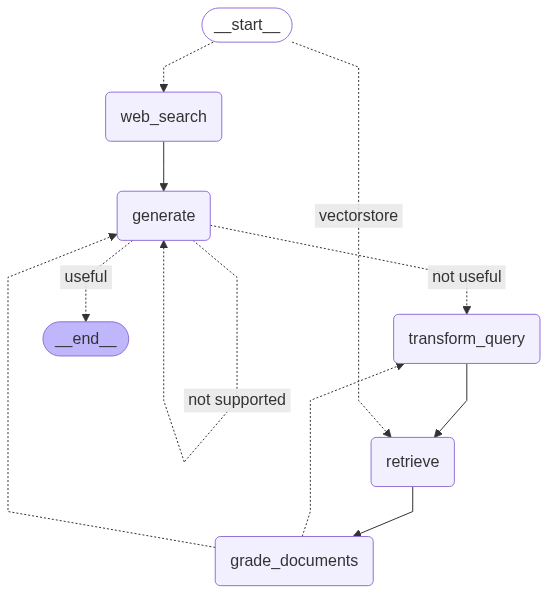

In [17]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass